# Analysis of Botswana MapBox Mobility Data

The purpose of this notebook is to visualize and assess the MapBox mobility data over Botswana for School and Non-School samples. The below analysis uses the hourly mobility data for October, November, December 2023.

MapBox Docs: https://docs.mapbox.com/data/movement/guides

The **Data Pre-Processing** section queries each school and non-school sample in the Botswana geojson cleaned schools file, and either calculates the MapBox mobility data per point that a sample (school or non-school) directly intersects with or generates a 300m buffer extent surrounding the school/non-school point and extracts the corresponding mobility data over that region. We cluster the data by either a 4-cluster system (representing North, West, East, South of the country, respectively) or Administrative Boundaries Level 1 and save the categorized data in the format of a dictionary of dataframes, saving via pickle. You can choose to go through each step of the data pre-processing to generate the dictionary of dataframes, or skip to the **Data Visualization** section to load the pickled dictionary and generate the plots.

## Imports and Setup

In [ ]:
import os
from scipy.stats import zscore
import requests
from io import StringIO
import pandas as pd
import folium
from shapely.geometry import Point
import geopandas as gpd
from functools import partial
import pyproj
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import transform
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import mercantile
from itertools import combinations
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sn
import pickle
import json
import stats
import copy
import numpy as np

## Loading Data

In [272]:
# Note: filepaths hard-coded to Kelsey Doerksen's local machine, to update
mobility_filepath = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility'

# Loading hourly mobility data
hourly_movement_df = pd.read_csv('{}/weekday-weekend-1hour.csv'.format(mobility_filepath))

# Loading 4-hour mobility day
day_of_week_4hour_df = pd.read_csv('{}/day_of_week-4hour.csv'.format(mobility_filepath))

# Loading BWA school geojson data
sample_df = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/BWA_train.geojson')

## Data Pre-Processing
We would like to aggregate and analyze the activity associated with individual school and non-school samples.


### Adding Mobility Information

### Intersection Analysis
We would like to spatially join the sample point layer with the MapBox mobility polygon layer, retaining the point geometries and grabbing the attributes of the intersecting polygons (i.e. the activity data)
Two methodologies:
1. Direct Intersection: mobility information if the target directly intersects with the available MapBox mobility data. 
2. Surrounding Buffer: mobility information for a user-defined buffer extent surrounding the target with the available MapBox mobility data. 
3. Intersection + Nearest Mobiltity porint: mobility information if the target directly intersects with available MapBox mobility data as well as for the nearest mobility data to school if there is no direct intersection

In [ ]:
def get_polygon_from_tile(geography):
    """
    Converts the mercantile quadkey to polygon
    
    Args:
        df: dataframe 
    """
    tile = mercantile.quadkey_to_tile(str(geography))
    return Polygon(mercantile.feature(tile)['geometry']['coordinates'][0])

In [ ]:
def add_mobility_data_intersection(movement_df, aoi_df):
    """
    Adds movement data to the school df
    :param: movement_df: dataframe of MapBox mobility data
    :param: aoi_df: df of aoi targets
    
    :return: aoi_df_with_mobility: df with added mobility data per aoi
    """
    # Add mercantile tile as polygon to movement df
    movement_df['mercantile_polygon'] = movement_df['geography'].apply(get_polygon_from_tile)
    # Change name to geometry
    movement_df = movement_df.rename(columns={'mercantile_polygon': 'geometry'})
    # Transform mobility data to gpd
    movement_gdf = gpd.GeoDataFrame(movement_df, crs="EPSG:4326")
    
    if 'geo' in school_df.columns:
        aoi_df = school_df.rename(columns={'geo': 'geometry'})
        aoi_df.set_geometry("geometry")

    # Combine aoi samples with mobility data
    aoi_with_mobility = aoi_df.sjoin(movement_gdf, how='left')

    # Drop if aoi does not intersect with available MapBox mobility data
    aoi_with_mobility = aoi_with_mobility.dropna(subset=["geography"])
    
    return aoi_with_mobility

In [ ]:
def aeqd_reproj_buffer(center, radius=300):
    """
    # Generate circular boundary around targets of user-specified 
    (defaut 300m) radius.
    Converts center coordinates to AEQD projection,
    draws a circle of given radius around the center coordinates,
    converts both polygons back to original ESRI:54009
    
    Args:
        center center coordinates of the circle (derived from school location)
        radius (integer): circle's radius in meters.
    
    Returns:
        A shapely.geometry Polygon object for circle of given radius.
    """
    lat = center.y
    lon = center.x
    
    esri54009_to_epsg4326 = Transformer.from_crs("ESRI:54009", "EPSG:4326", always_xy=True)
    epsg4326_to_aeqd = Transformer.from_crs("EPSG:4326", "ESRI:54032")
    aeqd_to_epsg4326 = Transformer.from_crs("ESRI:54032", "EPSG:4326", always_xy=False)

    # Transform the center coordinates from 54009 to AEQD
    point_epsg4326 = Point(esri54009_to_epsg4326.transform(lon, lat))
    point_transformed = Point(epsg4326_to_aeqd.transform(point_epsg4326.x, point_epsg4326.y))
    
    # Get buffer of defined radius
    buffer = point_transformed.buffer(radius)
    
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_epsg4326.transform, buffer)
    
    return circle_poly

In [ ]:
# Get a list of the mapbox data that is overlapping the radius extent we specified
def generate_quadkeys(circle_poly, zoom):
    """
    Generate a list of quadkeys that overlap our circles
    Args:
        circle_poly (shapely.geometry Polygon): circle polygon object drawn 
            around a school/non-school
        zoom (integer): zoom level.
        
    Return:
        List of quadkeys as string
    """
    return [mercantile.quadkey(x) for x in mercantile.tiles(*circle_poly.bounds, zoom)]

In [ ]:
def add_movement_data_buffer(sample_df, mobility_df):
    """
    Adding mobility data based on quadkey intersections for buffer analysis
    """
    full_data = []
    for i in range(len(sample_df)):
        data_list = []
        for z18_quadkey in sample_df.loc[i]["z18_quadkeys"]:
            data_list.append(mobility_df[mobility_df["geography"] == int(z18_quadkey)])
        data_df = pd.concat(data_list)
        data_df['UID'] = sample_df.loc[i]['UID']
        data_df['name'] = sample_df.loc[i]['name']
        full_data.append(data_df)
    
    if full_data:
        full_df = pd.concat(full_data)
        return full_df

In [ ]:
def add_movement_data(query_df, movement_df, month_subset, intersection_buffer):
    """
    Add movement data if MapBox quadkey exists
    Args:
        query_df: dataframe of aoi samples
        movement_df: MapBox mobility data df
        month_subset: month of movement data to query
        intersection_buffer: buffer extent for intersection of mobility data surrounding aoi
        
    Return:
        df with movement data
    """
    date_dict = {
        'oct': '2023-10-01',
        'nov': '2023-11-01',
        'dec': '2023-12-01'
    }
    print('Running for date subset: {}'.format(month_subset))
    
    # Make a copy of the df so we can filter things
    movement_df_copy = movement_df.copy(deep=True)
    
    # Subset movement dict to the time we are interested in
    if not month_subset == 'all':
        movement_df_copy = movement_df_copy[movement_df["start_date"] == date_dict['{}'.format(month_subset)]]
    
    if intersection_buffer == 0:
        samples_with_mobility = add_mobility_data_intersection(movement_df_copy, query_df)
        if not month_subset == 'all':
            samples_with_mobility_date_subset = samples_with_mobility[samples_with_mobility["start_date"] == date_dict['{}'.format(month_subset)]]
        else:
            return samples_with_mobility
    else:
        # Run for buffer
        samples_with_mobility_date_subset = add_movement_data_buffer(query_df, movement_df_copy)
    
    return samples_with_mobility_date_subset

In [ ]:
def calc_hourly_stat_ai(df, time_period, target, stat):
    """
    Aggregate movement data to hourly sum based on 
    quadkeys that interset with user-defined buffer
    and calculate the hourly average ai over 
    the time period for all of the samples
    :param: df: dataframe of aoi + mobility data to aggregate
    :time_period: weekday (0) or weekend(1) MapBox data
    :param: target: refers to the target we want to get stat for, ie activity_index_total, or some normalized version
    :param: stat: stat to calculate, mean or median
    """
    if pd.DataFrame(df) is None:
        return
    grouped = df.groupby(['UID', 'agg_day_period', 'agg_time_period', 'start_date', 'end_date'])
    sum_data = grouped[target].sum()
    sum_df = sum_data.reset_index()
    
    
    hourly_df = sum_df[sum_df['agg_day_period'] == int(time_period)]
    UIDS = hourly_df['UID'].unique().tolist()
    data_list =[]
    for uid in UIDS:
        hourly_df_uid = hourly_df[hourly_df['UID'] == uid]
        time_periods = hourly_df_uid['agg_time_period'].unique().tolist()
        df_list = []
        for t in time_periods:
            df_new = pd.DataFrame()
            subset_df = hourly_df_uid[hourly_df_uid['agg_time_period'] == t]
            sum_ai = subset_df[target].sum()
            df_new['agg_time_period'] = [t]
            df_new[target] = [sum_ai]
            df_new['UID'] = [uid]
            df_list.append(df_new)
        df_combined = pd.concat(df_list)
        data_list.append(df_combined)
    
    if len(data_list) < 0:
        return None
    df_final= pd.concat(data_list)
    if stat == 'mean':
        stat_hourly_data = hourly_df.groupby(['agg_time_period'])[target].mean()
    if stat == 'median'
        stat_hourly_data = hourly_df.groupby(['agg_time_period'])[target].mean()
    
    return stat_hourly_data

## Clustering based on Location
From MapBox: The data for each country is normalized within that country. Comparisons made over short timescales and short distances are more trustworthy than those made over long timescales and distances. Comparisons made over areas that have a high average activity are more trustworthy than those made over areas that have low average activity.

Several clustering methods are shown below; K-Means, Admin Boundary Level2, and Admin Boundary Level1

In [ ]:
# Get school data as coords
coords = []
for i in range(len(school_df)):
    coords.append([school_df.loc[i].geometry.x, school_df.loc[i].geometry.y])

In [ ]:
# Using elbow method to determine number of clusters we should use
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
def add_cluster_id(df, n_clusters):
    """
    Add cluster id to dataframe
    """
    # From plot, we see 4 is the optimal cluster number
    kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 5,  max_iter=400, n_init=10)
    y_kmeans = kmeans.fit_predict(coords)
    k=pd.DataFrame(y_kmeans, columns=['cluster'])
    
    # add cluster class to school dataframe
    df_with_cluster = df.join(k)
    
    return df_with_cluster

In [ ]:
# Add cluster id to dataframe
school_df_with_clusters = add_cluster_id(school_df, 4)

In [ ]:
filtered_label0 = school_df_with_clusters[school_df_with_clusters['cluster'] == 0]
filtered_label1 = school_df_with_clusters[school_df_with_clusters['cluster'] == 1]
filtered_label2 = school_df_with_clusters[school_df_with_clusters['cluster'] == 2]
filtered_label3 = school_df_with_clusters[school_df_with_clusters['cluster'] == 3]

plt.scatter(filtered_label0.geometry.x, filtered_label0.geometry.y, label='Cluster 0')
plt.scatter(filtered_label1.geometry.x, filtered_label1.geometry.y, label='Cluster 1')
plt.scatter(filtered_label2.geometry.x, filtered_label2.geometry.y, label='Cluster 2')
plt.scatter(filtered_label3.geometry.x, filtered_label3.geometry.y, label='Cluster 3')
plt.legend()
plt.title('K-Means Clustered School and Non-school samples')
plt.show()

## Clustering via administrative boundaries
We can also cluster via administrative boundaries, let's do this and see how many clusters we get, combining very small clusters together as MapBox notes that this is an ineffective way to analyze data

In [ ]:
def cluster_via_adm(sample_df, adm_level):
    """
    Function to cluster data via ADM boundaries
    :param: sample_df: df of school and non-school samples to cluster
    :param: adm_level: administrative level to query for generating clusters
    """
    # Load country admin levels
    country_adm_levels = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/geoBoundaries-BWA-ADM{}.geojson'.format(adm_level))
    
    # Transform sample df to EPSG4326
    sample_df_epsg4326 = sample_df.to_crs('EPSG:4326')
    
    # Get intersection of sample df with admin boundaries
    sample_df_with_intersections = gpd.overlay(sample_df_epsg4326, country_adm_levels, how='intersection')
    
    # Plot clusters to observe
    clusters = sample_df_with_intersections ['shapeName'].unique()
    plt. figure(figsize=(8, 6))
    for i in range(len(clusters)):
        filt = sample_df_with_intersections [sample_df_with_intersections ['shapeName'] == clusters[i]]
        plt.scatter(filt.geometry.x, filt.geometry.y, label=clusters[i])

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Botswana ADM{} Boundary School/Non-School Sample Clustering'.format(adm_level))
    plt.show()
    
    return sample_df_with_intersections

In [ ]:
# Clustering based on ADM2
school_df_with_clusters_adm2 = cluster_via_adm(school_df, 2)

In [ ]:
# Clustering based on ADM1
school_df_with_clusters = cluster_via_adm(school_df, 1)

Looking at above clustering methods, clustering via adminstrative boundaries level 2 may result in too small of sample sizes, which will result in our Mobility analysis not being meaningful. **We will proceed with Admin Boundaries 1 clustering**

# Intersection and Nearest Mobility Point Analysis
This analysis is to add mobility data for each of the samples based on the nearest mobility data to aoi

In [330]:
def mobility_aoi_nearest(mobility_df, aoi_df):
    """
    Add the mobility data point for closest data to aoi
    :param: mobility_df: dataframe of mobility data
    :param: aoi_df: df of samples
    
    :return: 
    """
    # Making some copies of the mobility, aoi df so we can manipulate without impacting original
    mobility_df = mobility_df.copy(deep=True)
    aoi_gpd = aoi_df.copy(deep=True)
    
    # Add mercantile information to mobility gpd so we can get polygon
    mobility_df['mercantile_polygon'] = hourly_movement_df['geography'].apply(get_polygon_from_tile)
    mobility_df = mobility_df.rename(columns={'mercantile_polygon': 'geometry'})
    mobility_gpd = gpd.GeoDataFrame(mobility_df, crs='EPSG:4326')
    
    
    # Update CRS so that we can calculate nearest point
    aoi_gpd = aoi_gpd.to_crs('EPSG:3857')
    mobility_gpd = mobility_gpd.to_crs('EPSG:3857')

    combo_df = gpd.sjoin_nearest(mobility_gpd, aoi_gpd, how='left', distance_col = 'dist_to_mobility')
    
    # Get T/F mobility intersection as 0/1 for filtering and to teach model as feature
    intersected = combo_df['dist_to_mobility'] == 0
    combo_df['intersecting_mobility'] = intersected.astype(int)
    
    return combo_df

In [331]:
test_df = mobility_aoi_nearest(hourly_movement_df, sample_df)

### School and Non-School Sample Selection
For initial demo, 3 schools and non-schools are selected randomly via QGIS manual inspection in rural and urban areas based on the definition in the BWA_train.gejson file. 

Non-Schools are selected by finding a close non-school point to a school point.

The definitions of each type of non-school are from their UID is:

Urban:
- OSM-BWA-NON_SCHOOL-00000835: Cloud Networks Business Center
- OSM-BWA-NON_SCHOOL-00000849: Mmopane Police
- OVERTURE-BWA-NON_SCHOOL-00000420: Mbizi Guest House Sebina

Rural: 
- OSM-BWA-NON_SCHOOL-00000813: Bokspits Clinic
- OSM-BWA-NON_SCHOOL-00000561: Sanitary Checkpoint
- OSM-BWA-NON_SCHOOL-00000027: Game Scouts - Park Entry


In [ ]:
# Uncomment if you would like to only run on a small subset of the schools

# Subsetting data into rural-school, rural-nonschool, urban-school, urban-nonschool
# Samples selected based on visiual inspection in QGIS 
'''
urban_schools_subset = ['OSM-BWA-SCHOOL-00000103', 'OSM-BWA-SCHOOL-00000152', 'UNICEF-BWA-SCHOOL-00000048']
rural_schools_subset = ['UNICEF-BWA-SCHOOL-00000335', 'UNICEF-BWA-SCHOOL-00000683', 'UNICEF-BWA-SCHOOL-00000096']
urban_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000835', 'OSM-BWA-NON_SCHOOL-00000849', 'OVERTURE-BWA-NON_SCHOOL-00000420']
rural_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000813', 'OSM-BWA-NON_SCHOOL-00000561', 'OSM-BWA-NON_SCHOOL-00000027']

rural_school_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_schools)]
urban_school_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_schools)]
rural_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_non_schools)]
urban_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_non_schools)]
'''

## Dictionary Functions
Below functions are used to generate the cluster dictionary based on the defined categories for schools and non-schools for subsetting the data

In [ ]:
def generate_cluster_dict(cluster_name, df, timeperiod):
    """
    Creates a dictionary of relevant dfs per cluster
    :param: cluster_name: cluster id
    :param: df: dataframe of samples
    :param: timeperiod: time period of analysis, weekday or weekend
    
    :return: dictionary of dataframes for the cluster
    """
    school_df = df[df['class'] == 'school']
    nonschool_df = df[df['class'] == 'non_school']
    
    if timeperiod == 'weekday':
        school_df = school_df[school_df['agg_day_period'] == 0]
        nonschool_df = nonschool_df[nonschool_df['agg_day_period'] == 0]
    if timeperiod == 'weekend':
        school_df = school_df[school_df['agg_day_period'] == 1]
        nonschool_df = nonschool_df[nonschool_df['agg_day_period'] == 1]
    
    cluster_dict = {}
    cluster_dict['schools_{}_ai'.format(timeperiod)] = school_df[school_df['cluster'] == cluster_name].reset_index().drop(columns=['index'])
    cluster_dict['nonschools_{}_ai'.format(timeperiod)] = nonschool_df[nonschool_df['cluster'] == cluster_name].reset_index().drop(columns=['index'])
    
    # Defining building types for non-schools (to update to not have to make case sensitive)
    clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
    police = ['police', 'Police']
    farm = ['farm', 'Farm']
    
    # Dropping samples with no names for nonschools as we can't identify these by category
    nonschools_no_nan = nonschool_df.dropna(subset=['name'])
    
    # Adding filtered non-schools for cluster to dictionary
    cluster_dict['clinics_{}_ai'.format(timeperiod)] = filter_df(nonschools_no_nan, clinics)
    cluster_dict['police_{}_ai'.format(timeperiod)] = filter_df(nonschools_no_nan, police)
    cluster_dict['farms_{}_ai'.format(timeperiod)] = filter_df(nonschools_no_nan, farm)
    
    # Subset for urban and rural schools
    cluster_dict['urban_schools_{}_ai'.format(timeperiod)] = school_df[school_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_schools_{}_ai'.format(timeperiod)] = school_df[school_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    # Subset for urban and rural nonschools
    cluster_dict['urban_nonschools_{}_ai'.format(timeperiod)] = nonschool_df[nonschool_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_nonschools_{}_ai'.format(timeperiod)] = nonschool_df[nonschool_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    return cluster_dict

In [ ]:
# Loop through dataframes per cluster and add movement data, then normalize
# Old function
def generate_hourly_movement_per_cluster(cluster_dict, cluster_id, intersection):
    """
    Generate a dictionary for cluster specified of 
    normalized hourly movement data
    :param: cluster_dict: dictionary of dataframes per cluster
    :param: cluster_id: cluster id
    :param: intersection: integer representing buffer extent, if 0, represents direct intersection
    :return: dictionary of hourly weekday and weekend mobility data
    """
    mobility_cluster_dict = {'oct': None, 'nov': None, 'dec': None, 'all': None}
    dates = ['oct', 'nov', 'dec', 'all']
    for date in dates:
        date_dict = {}
        for key in cluster_dict.keys():
            df = cluster_dict[key]
            print('Running for key: {}'.format(key))
            df_with_movement = add_movement_data(df, hourly_movement_df, date, intersection)
            movement_hourly_weekday = calc_hourly_average_ai(df_with_movement, 0)
            movement_hourly_weekend = calc_hourly_average_ai(df_with_movement, 1)
            
            # normalize so we can cross-compare regions
            if movement_hourly_weekday is not None:
                movement_hourly_weekday_norm = max_min_normalize(movement_hourly_weekday)
            else:
                movement_hourly_weekday_norm = None
            if movement_hourly_weekend is not None:
                movement_hourly_weekend_norm = max_min_normalize(movement_hourly_weekend)
            else:
                movement_hourly_weekend_norm = None
            
            date_dict['{}_hourly_weekday_ai'.format(key)] = movement_hourly_weekday_norm
            date_dict['{}_hourly_weekend_ai'.format(key)] = movement_hourly_weekend_norm
        mobility_cluster_dict[date] = date_dict
    
    return mobility_cluster_dict

In [ ]:
# Loop through dataframes per cluster and add movement data
# Old function
def add_movement_per_cluster(cluster_dict, cluster_id, intersection):
    """
    Generate dictionary of movement data
    :param: cluster_dict: dictionary of dataframes per cluster
    :param: cluster_id: cluster id
    :param: intersection: integer representing buffer extent, if 0, represents direct intersection
    :return: dictionary of hourly weekday and weekend mobility data
    """
    mobility_cluster_dict = {'oct': None, 'nov': None, 'dec': None, 'all': None}
    dates = ['oct', 'nov', 'dec', 'all']
    for date in dates:
        date_dict = {}
        for key in cluster_dict.keys():
            df = cluster_dict[key]
            print('Running for key: {}'.format(key))
            df_with_movement = add_movement_data(df, hourly_movement_df, date, intersection)
            df_with_movement_weekday = df_with_movement[df_with_movement['agg_day_period'] == 0]
            df_with_movement_weekend = df_with_movement[df_with_movement['agg_day_period'] == 1]
            
            date_dict['{}_weekday_ai'.format(key)] = df_with_movement_weekday
            date_dict['{}_weekend_ai'.format(key)] = df_with_movement_weekend
        mobility_cluster_dict[date] = date_dict
    
    return mobility_cluster_dict

In [ ]:
def filter_df(df, filter_list):
    """
    Filter df based on filtering list criteria
    """
    df_list = []
    for criteria in filter_list:
        filt_df = df[df['name'].str.contains(criteria)]
        filt_df = filt_df.rename(columns={"geometry": "geo"})
        df_list.append(filt_df)
    
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    return combined_df

## Plotting Function(s)

In [ ]:
# Plotting function
def plot_activity_index(df, cluster_name, category, time, month):
    """
    Function to plot activity index. 
    Call plt.show() after function
    :param df: dataframe of activity data
    :param cluster_name: name of cluster 
    :param category: category of df, i.e school, non-school, clinic, etc.
    :param time: weekday or weekend
    :param month: month of analysis
    """
    month_dict = {
        'oct': 'October',
        'nov': 'November',
        'dec': 'December'
    }
    plt.plot(df.index, df['activity_index_total'], label='{}'.format(time))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
    plt.xlim(0,23)
    plt.ylim(0,1)
    plt.xlabel('Hour of Day')
    plt.ylabel('Activity Index')
    plt.title('{} {} Activity Index'.format(month_dict[month], cluster_name))

# Intersection Analysis 4 Clusters

In [ ]:
# Add cluster id to samples
sample_df_with_clusters = add_cluster_id(sample_df, 4)

In [ ]:
# Add mobility data based on intersection
# Change crs to EPSG 4326
sample_df_with_clusters = sample_df_with_clusters.to_crs('EPSG:4326')

mobility_dict = {}
months = ['oct','nov','dec','all']
for month in months:
    mobility_dict[month] = add_movement_data(sample_df_with_clusters, hourly_movement_df, month, 0)

In [ ]:
# Z-score standardization on all samples
for m in mobility_dict.keys():
    mobility_dict[m]['z_activity_index_total'] = (mobility_dict[m]['activity_index_total'] - mobility_dict[m]['activity_index_total'].mean()) / mobility_dict[m]['activity_index_total'].std()

In [ ]:
cluster_names = sample_df_with_clusters['cluster'].unique()

In [ ]:
# Run data dict generation
data_dict = {}
month_dict = {}
months = ['oct','nov','dec','all']
for month in months:
    for name in cluster_names:
        weekday = generate_cluster_dict(name, mobility_dict[month], 'weekday')
        weekend = generate_cluster_dict(name, mobility_dict[month], 'weekend')
        weekday.update(weekend)
        data_dict[name] = weekday
    pickle.dump(data_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_4clusters_{}.p".format(month), "wb" ))

In [ ]:
# Iterate through the months and then load data, then make the aggregation and save
dates = ['oct', 'nov', 'dec', 'all']
for d in dates:
    data = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_4clusters_{}_zcore_norm.p'.format(d), 'rb'))
    data_copy = copy.deepcopy(data)
    weekday_keys = ['schools_weekday_ai', 'nonschools_weekday_ai', 'clinics_weekday_ai', 'police_weekday_ai', 'farms_weekday_ai', 'urban_schools_weekday_ai', 'rural_schools_weekday_ai', 'urban_nonschools_weekday_ai', 'rural_nonschools_weekday_ai']
    weekend_keys = ['schools_weekend_ai', 'nonschools_weekend_ai', 'clinics_weekend_ai', 'police_weekend_ai', 'farms_weekend_ai', 'urban_schools_weekend_ai', 'rural_schools_weekend_ai', 'urban_nonschools_weekend_ai', 'rural_nonschools_weekend_ai']

    for cluster_id in data_copy.keys():
        for wdkey in weekday_keys:
            data_copy[cluster_id][wdkey] = calc_hourly_average_ai(data_copy[cluster_id][wdkey], 0, 'activity_index_total')
        for wekey in weekend_keys:
            data_copy[cluster_id][wekey] = calc_hourly_average_ai(data_copy[cluster_id][wekey], 1, 'activity_index_total')
    
    # Pickle the aggregated data
    pickle.dump(data_copy, open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_mobility_dfs_4clusters_{}.p".format(month), "wb" ))

#### Old method

In [ ]:
# ---- OLD METHOD ----

# Subset into school and nonschool
school_samples_df = school_df_with_clusters.copy(deep=True)[school_df_with_clusters['class'] == 'school']
nonschool_samples_df = school_df_with_clusters.copy(deep=True)[school_df_with_clusters['class'] == 'non_school']

school_samples_df = school_samples_df.rename(columns={'cluster': 'shapeName'})
nonschool_samples_df = nonschool_samples_df.rename(columns={'cluster': 'shapeName'})
school_df_with_clusters = school_df_with_clusters.rename(columns={'cluster': 'shapeName'})

school_df_with_clusters = school_df_with_clusters.to_crs('EPSG:4326')
school_samples_df = school_samples_df.to_crs('EPSG:4326')
nonschool_samples_df = nonschool_samples_df.to_crs('EPSG:4326')

# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)
    
pickle.dump(data_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_unfiltered_mobility_dfs_4clusters.p", "wb" ))
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key, 0)

# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs_4clusters.p", "wb" ))

# Generating mobility clusters without aggregation to down-select several samples
# Generate mobility clusters
data_mobility_dict_no_agg = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict_no_agg['{}'.format(key)] = add_movement_per_cluster(data_dict[key], key, 0)
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict_no_agg, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_mobility_dfs_no_agg_4clusters.p", "wb" ))

# Intersection Analysis ADM1 Clusters
Below analysis is for using only the MapBox data for which the school/non-school samples directly overlap the z18 quadkey tile for

In [ ]:
# Add cluster id to samples
sample_df_with_clusters_adm1 = cluster_via_adm(sample_df, 1)

In [ ]:
sample_df_with_clusters_adm1 = sample_df_with_clusters_adm1.rename(columns={'shapeName': 'cluster'})

In [ ]:
# Add mobility data based on intersection
# Change crs to EPSG 4326
sample_df_with_clusters_adm1 = sample_df_with_clusters_adm1.to_crs('EPSG:4326')

mobility_dict = {}
months = ['oct','nov','dec','all']
for month in months:
    mobility_dict[month] = add_movement_data(sample_df_with_clusters_adm1, hourly_movement_df, month, 0)

In [ ]:
# Z-score standardization on all samples
for m in mobility_dict.keys():
    mobility_dict[m]['z_activity_index_total'] = (mobility_dict[m]['activity_index_total'] - mobility_dict[m]['activity_index_total'].mean()) / mobility_dict[m]['activity_index_total'].std()

In [ ]:
cluster_names = sample_df_with_clusters_adm1['cluster'].unique()

In [ ]:
# Run data dict generation
data_dict = {}
month_dict = {}
months = ['oct','nov','dec','all']
for month in months:
    for name in cluster_names:
        weekday = generate_cluster_dict(name, mobility_dict[month], 'weekday')
        weekend = generate_cluster_dict(name, mobility_dict[month], 'weekend')
        weekday.update(weekend)
        data_dict[name] = weekday
    pickle.dump(data_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_adm1_{}.p".format(month), "wb" ))

In [ ]:
# Aggregating by Mean
# Iterate through the months and then load data, then make the aggregation and save
dates = ['oct', 'nov', 'dec', 'all']
for d in dates:
    data = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_adm1_{}_zscore_norm.p'.format(d), 'rb'))
    data_copy = copy.deepcopy(data)
    weekday_keys = ['schools_weekday_ai', 'nonschools_weekday_ai', 'clinics_weekday_ai', 'police_weekday_ai', 'farms_weekday_ai', 'urban_schools_weekday_ai', 'rural_schools_weekday_ai', 'urban_nonschools_weekday_ai', 'rural_nonschools_weekday_ai']
    weekend_keys = ['schools_weekend_ai', 'nonschools_weekend_ai', 'clinics_weekend_ai', 'police_weekend_ai', 'farms_weekend_ai', 'urban_schools_weekend_ai', 'rural_schools_weekend_ai', 'urban_nonschools_weekend_ai', 'rural_nonschools_weekend_ai']

    for cluster_id in data_copy.keys():
        for wdkey in weekday_keys:
            data_copy[cluster_id][wdkey] = calc_hourly_average_ai(data_copy[cluster_id][wdkey], 0, 'activity_index_total')
        for wekey in weekend_keys:
            data_copy[cluster_id][wekey] = calc_hourly_average_ai(data_copy[cluster_id][wekey], 1, 'activity_index_total')
    
    # Pickle the aggregated data
    pickle.dump(data_copy, open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_mobility_dfs_adm1_{}.p".format(d), "wb" ))

In [ ]:
# Aggregating by Median
# Iterate through the months and then load data, then make the aggregation and save
dates = ['oct', 'nov', 'dec', 'all']
for d in dates:
    data = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_adm1_{}_zscore_norm.p'.format(d), 'rb'))
    data_copy = copy.deepcopy(data)
    weekday_keys = ['schools_weekday_ai', 'nonschools_weekday_ai', 'clinics_weekday_ai', 'police_weekday_ai', 'farms_weekday_ai', 'urban_schools_weekday_ai', 'rural_schools_weekday_ai', 'urban_nonschools_weekday_ai', 'rural_nonschools_weekday_ai']
    weekend_keys = ['schools_weekend_ai', 'nonschools_weekend_ai', 'clinics_weekend_ai', 'police_weekend_ai', 'farms_weekend_ai', 'urban_schools_weekend_ai', 'rural_schools_weekend_ai', 'urban_nonschools_weekend_ai', 'rural_nonschools_weekend_ai']

    for cluster_id in data_copy.keys():
        for wdkey in weekday_keys:
            data_copy[cluster_id][wdkey] = calc_hourly_median_ai(data_copy[cluster_id][wdkey], 0, 'activity_index_total')
        for wekey in weekend_keys:
            data_copy[cluster_id][wekey] = calc_hourly_median_ai(data_copy[cluster_id][wekey], 1, 'activity_index_total')
    
    # Pickle the aggregated data
    pickle.dump(data_copy, open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_median_mobility_dfs_adm1_{}.p".format(d), "wb" ))

# Intersection Analysis ADM2 Clusters
Below analysis is for using only the MapBox data for which the school/non-school samples directly overlap the z18 quadkey tile for

#### Old, to update

In [ ]:
# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)

In [ ]:
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key, 0)

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs.p", "wb" ))

In [ ]:
# Generating mobility clusters without aggregation to down-select several samples
# Generate mobility clusters
data_mobility_dict_no_agg = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict_no_agg['{}'.format(key)] = add_movement_per_cluster(data_dict[key], key, 0)

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict_no_agg, open( "/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/dict_of_mobility_dfs_no_agg.p", "wb" ))

## Data Visualization

In [ ]:
# Loading pickled data
data_mobility_dict_inter = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_mobility_dfs_adm1_nov.p", "rb"))

In [ ]:
save_directory = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/Mobility_Analysis_Figs'

In [ ]:
cluster_name = 'South-East District'

## To update below

In [ ]:
# Plotting per cluster for November
for cluster_name in list(data_mobility_dict_inter.keys()):
    print('Plotting for cluster: {}'.format(cluster_name))
    # Plotting weekend activity of schools, nonschools
    if data_mobility_dict_inter[cluster_name]['schools_weekend_ai'] is None:
        continue
    plt.figure(figsize=(10, 6))
    plot_activity_index(data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekend_ai'], cluster_name, 'Schools Weekend', 'Weekend', m)
    plot_activity_index(data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekday_ai'], cluster_name, 'Schools Weekday', 'Weekday', m)
    plt.savefig('{}/{}_schools_cluster_{}.png'.format(save_directory, m, cluster_name))
    plt.show()
    plt.close()

In [ ]:
# Plotting per cluster per month for Non-Schools
months = ['oct', 'nov', 'dec']
for cluster_name in list(data_mobility_dict_inter.keys()):
    print('Plotting for cluster: {}'.format(cluster_name))
    for m in months:
        # Plotting weekend activity of schools, nonschools
        if data_mobility_dict_inter[cluster_name][m]['nonschools_hourly_weekend_ai'] is None:
            continue
        plt.figure(figsize=(10, 6))
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['nonschools_hourly_weekend_ai'], cluster_name, 'Schools Weekend', 'Weekend', m)
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['nonschools_hourly_weekday_ai'], cluster_name, 'Schools Weekday', 'Weekday', m)
        plt.savefig('{}/{}_nonschools_cluster_{}.png'.format(save_directory, m, cluster_name))
        plt.show()
        plt.close()

In [ ]:
# Plotting per cluster per month for Schools and Non-Schools Weekday
months = ['oct', 'nov', 'dec']
for cluster_name in list(data_mobility_dict_inter.keys()):
    print('Plotting for cluster: {}'.format(cluster_name))
    for m in months:
        # Plotting weekday activity of schools, nonschools
        if data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekday_ai'] is None:
            continue
        plt.figure(figsize=(10, 6))
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekday_ai'], cluster_name, 'Schools Weekday', 'Schools Weekday', m)
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['nonschools_hourly_weekday_ai'], cluster_name, 'NonSchools Weekday', 'NonSchools Weekday', m)
        plt.savefig('{}/{}_schools_vs_nonschools_weekday_cluster_{}.png'.format(save_directory, m, cluster_name))
        plt.show()
        plt.close()

In [ ]:
# Plotting per cluster per month for Schools and Non-Schools Weekend
months = ['oct', 'nov', 'dec']
for cluster_name in list(data_mobility_dict_inter.keys()):
    print('Plotting for cluster: {}'.format(cluster_name))
    for m in months:
        # Plotting weekend activity of schools, nonschools
        if data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekend_ai'] is None:
            continue
        plt.figure(figsize=(10, 6))
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['schools_hourly_weekend_ai'], cluster_name, 'Schools Weekend', 'Schools Weekend', m)
        plot_activity_index(data_mobility_dict_inter[cluster_name][m]['nonschools_hourly_weekend_ai'], cluster_name, 'NonSchools Weekend', 'NonSchools Weekend', m)
        plt.savefig('{}/{}_schools_vs_nonschools_weekend_cluster_{}.png'.format(save_directory, m, cluster_name))
        plt.show()
        plt.close()

# Buffer Analysis

1. Define 300m boundary for each school/non-school sample
2. Get a list of MapBox quadkey tiles that overlap school/non-school buffer zone
3. Take summary statistics of MapBox movement data

In [ ]:
# Get circle buffer and add to school_df
school_df['aeqd_reproj_circle'] = school_df['geometry'].apply(aeqd_reproj_buffer)

In [ ]:
# Add zoom level 18 quadkeys to school dataset
school_df['z18_quadkeys'] = school_df.apply(lambda x: generate_quadkeys(x['aeqd_reproj_circle'], 18),axis=1)

### Subset Non-Schools based on building type
We know that our ML models struggle with False Positives on samples represented by hospitals & clinics, police stations and farmsteads. In theory, the activity level around these types of buildings vs schools should be different, so we would like to subset the samples by these categories to observe

In [ ]:
# Dropping nans from samples because we can't associate them with building type if not defined
school_df_no_nan = nonschool_samples_df.dropna(subset=['name'])

In [ ]:
# Defining building types for non-schools (to update to not have to make case sensitive)
clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
police = ['police', 'Police']
farm = ['farm', 'Farm']

In [ ]:
clinic_df = filter_df(school_df_no_nan, clinics)
police_df = filter_df(school_df_no_nan, police)
farm_df = filter_df(school_df_no_nan, farm)

### Subsetting data into Clusters by Administrative Zones

In [ ]:
# Create cluster dictionaries
cluster_names = school_df_with_clusters['shapeName'].unique()
data_dict = {}
for name in cluster_names:
    data_dict['{}'.format(name)] = generate_cluster_dict(name, school_samples_df, nonschool_samples_df)

In [ ]:
# Generate mobility clusters
data_mobility_dict = {}
for key in data_dict.keys():
    print('Running for key: {}'.format(key))
    data_mobility_dict['{}'.format(key)] = generate_hourly_movement_per_cluster(data_dict[key], key)

In [ ]:
# Save so we don't need to re-run a bunch of times
pickle.dump(data_mobility_dict, open( "Users/kdoerksen/dict_of_mobility_dfs_300m_buffer.p", "wb" ))

## Data Visualzation

In [ ]:
# Loading pickled data
data_mobility_dict = pickle.load(open("Users/kdoerksen/dict_of_mobility_dfs_300m_buffer.p", "rb"))

## Category Data Visualization

### Schools

In [ ]:
school_samples_df = school_samples_df.reset_index().drop(columns=['index'])
school_samples_df_with_movement = add_movement_data(school_samples_df, hourly_movement_df, 'nov')
school_samples_hourly_weekday = calc_hourly_average_ai(school_samples_df_with_movement,0)
# Plotting
plot_activity_index(school_samples_hourly_weekday, 'Schools', 'schools', 'Weekday', marker='off')
plt.show()

### Non-Schools

In [ ]:
nonschool_samples_df = school_samples_df.reset_index().drop(columns=['index'])
nonschool_samples_df_with_movement = add_movement_data(nonschool_samples_df, hourly_movement_df, 'nov')
nonschool_samples_hourly_weekday = calc_hourly_average_ai(nonschool_samples_df_with_movement,0)
# Plotting
plot_activity_index(nonschool_samples_hourly_weekday, 'Non-Schools', 'schools', 'Weekday', marker='off')
plt.show()

### Clinics

In [ ]:
clinic_df = clinic_df.reset_index().drop(columns=['index'])
clinic_df_with_movement = add_movement_data(clinic_df, hourly_movement_df, 'nov')
clinic_df_sum_hourly_weekday = calc_hourly_average_ai(clinic_df_with_movement,0)
clinic_df_sum_hourly_weekend = calc_hourly_average_ai(clinic_df_with_movement,1)

In [ ]:
# Plotting
plot_activity_index(clinic_df_sum_hourly_weekday, 'Clinic', 'clinic', 'Weekday', marker='on')
plt.show()

### Police Stations

In [ ]:
police_df = police_df.reset_index().drop(columns=['index'])
police_df_with_movement = add_movement_data(police_df, hourly_movement_df, 'nov')
police_df_sum_hourly_weekday = calc_hourly_average_ai(police_df_with_movement,0)
police_df_sum_hourly_weekend = calc_hourly_average_ai(police_df_with_movement,1)

In [ ]:
# Plotting
plot_activity_index(police_df_sum_hourly_weekday, 'Police', 'police', 'Weekday', marker='on')
plt.show()

### Farms

In [ ]:
farm_df = farm_df.reset_index().drop(columns=['index'])
farm_df_with_movement = add_movement_data(farm_df, hourly_movement_df, 'nov')
farm_df_sum_hourly_weekday = calc_hourly_average_ai(farm_df_with_movement,0)

In [ ]:
# Plotting
plot_activity_index(farm_df_sum_hourly_weekday, 'Farm', 'farm', 'Weekday', marker='on')
plt.show()

### Schools, Clinics, Police, Farms

In [ ]:
plt.figure(figsize=(10, 6))
plot_activity_index(school_samples_hourly_weekday, 'Schools', 'schools', 'Weekday')
plot_activity_index(clinic_df_sum_hourly_weekday, 'Clinic', 'clinic', 'Weekday')
plot_activity_index(police_df_sum_hourly_weekday, 'Police', 'police', 'Weekday')
plot_activity_index(farm_df_sum_hourly_weekday, 'Farm', 'farm', 'Weekday')
plt.show()

## Clustered Data Visualization

## Plotting
Hard-coding for Southern District, November, can be updated based on what cluster you want to analyze

In [ ]:
cluster_id = 'Southern District'

In [ ]:
# Plotting weekday schools, police, clinics and farms
schools_marker_sizes= data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai']['measurements_count']
police_marker_sizes= data_mobility_dict[cluster_id]['nov']['police_hourly_weekday_ai']['measurements_count']
clinics_marker_sizes= data_mobility_dict[cluster_id]['nov']['clinics_hourly_weekday_ai']['measurements_count']
farms_marker_sizes= data_mobility_dict[cluster_id]['nov']['farms_hourly_weekday_ai']['measurements_count']

plt. figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai'], cluster_id, 'Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['police_hourly_weekday_ai'], cluster_id, 'Police', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['clinics_hourly_weekday_ai'], cluster_id, 'Clinics', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['farms_hourly_weekday_ai'], cluster_id, 'Farms', 'Weekday')
plt.show()

### Temporal Comparison

In [ ]:
plt.figure(figsize=(10, 6))
plot_activity_index(data_mobility_dict[cluster_id]['oct']['schools_hourly_weekday_ai'], cluster_id, 'Oct Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['nov']['schools_hourly_weekday_ai'], cluster_id, 'Nov Schools', 'Weekday')
plot_activity_index(data_mobility_dict[cluster_id]['dec']['schools_hourly_weekday_ai'], cluster_id, 'Dec Schools', 'Weekday')
plt.show()

## Cluster Comparison Schools

In [ ]:
plt. figure(figsize=(20, 10))
for adm_zone in data_mobility_dict.keys():
    plot_activity_index(data_mobility_dict[adm_zone]['oct']['schools_hourly_weekday_ai'], adm_zone, 'Nov Schools', 'Weekday')
plt.title('All Cluster School Analaysis November')
plt.show()

# Plotting for Tech Demo

In [ ]:
root_dir = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility'

# Hourly average Cluster
Format for accessing the aggregated data for district is dict[cluster name][schools_weekday_ai] etc

# Sample Selection for MapBox Mobility Presentation
Below code is used for the investigative analysis of MapBox mobility data for school and non-school prediction on a sample basis across Botswana. Two clustering methods are used, one clustering based on the Administrative zones level 2, the other clustering based on the elbow method using 4 clusters (representing respectively North, South, East, West part of Botswana).

In [155]:
def get_top_5_aois(mobility_dict, cluster_id, target_type):
    """
    Get the top 5 school/non-school (or target)
    UIDs ranked by the number of mobility data hits
    
    :param: mobility_dict: dictionary of mobility data we are filtering
    :param: cluster_id: id of the cluster we are querying
    :param: target_type: aoi type we are querying, schools, nonschools, weekend, weekday
    """
    return {target_type: dict(mobility_dict[cluster_id][target_type]['UID'].value_counts()[0:5])}

In [157]:
def plotting_top_5_aois(mobility_dict, top_5, cluster_id, time_period, results_dir):
    """
    Plotting the top 5 AOIS per cluster per type
    :param: mobility_dict: dict of all mobility data to subset
    :param: top_5: dictionary of top 5 aois from number of mobility points
    :param: cluster_id: cluster id to subset df
    :param: time_period: weekday or weekend analysis
    :param: results_dir: directory to save figures to
    
    """
    
    # Subset dictionary into weekday, weekend schools and non-schools to plot
    # Loading all because I have hard-coded the integer order of the data in the list so makes it easier
    top_5_schools_weekday = list(top_5[cluster_id][0]['schools_weekday_ai'].keys())
    top_5_schools_weekend = list(top_5[cluster_id][1]['schools_weekend_ai'].keys())
    top_5_nonschools_weekday = list(top_5[cluster_id][2]['nonschools_weekday_ai'].keys())
    top_5_nonschools_weekend = list(top_5[cluster_id][3]['nonschools_weekend_ai'].keys())
    
    # Now let's subset the mobility_dict of information for the top 5 entries respectively and plot this all
    
    # Create dfs of subset by time_period
    df_schools_weekday_ai = mobility_dict[cluster_id]['schools_weekday_ai']
    df_schools_weekend_ai = mobility_dict[cluster_id]['schools_weekend_ai']
    df_nonschools_weekday_ai = mobility_dict[cluster_id]['nonschools_weekday_ai']
    df_nonschools_weekend_ai = mobility_dict[cluster_id]['nonschools_weekend_ai']
    
    
    # Iterate through the top 5 aois and get their activity data over time
    if time_period == 'weekday':
        # Save information to list
        x_list_schools, y_list_schools, x_list_nonschools, y_list_nonschools = [], [], [], []
        for school in top_5_schools_weekday:
            df_sorted = df_schools_weekday_ai[df_schools_weekday_ai['UID'] == school].sort_values(by='agg_time_period')
            x_list_schools.append(df_sorted['agg_time_period'].to_list())
            y_list_schools.append(df_sorted['activity_index_total'].to_list())
        for nonschool in top_5_nonschools_weekday:
            df_sorted = df_nonschools_weekday_ai[df_nonschools_weekday_ai['UID'] == nonschool].sort_values(by='agg_time_period')
            x_list_nonschools.append(df_sorted['agg_time_period'].to_list())
            y_list_nonschools.append(df_sorted['activity_index_total'].to_list())
            

        # Plotting the 5 AOIs for Schools
        print('---- Plotting for Schools ----')
        num_samples = len(top_5_schools_weekday)
        for i in range(num_samples):
            plt.plot(x_list_schools[i], y_list_schools[i], label=top_5_schools_weekday[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
        plt.xlim(0,23)
        plt.ylim(0,1)
        plt.xlabel('Hour of Day')
        plt.ylabel('Activity Index')
        plt.title('Top {} School AOI Activity Index during {} for Cluster {}'.format(num_samples, time_period, cluster_id))
        plt.show()
        #plt.savefig('{}/school_aoi_top5_{}_{}_cluster_{}.png'.format(results_dir,month, time_period, cluster_id))
        plt.close()
        
        # Plotting the 5 AOIs for NonSchools
        print('---- Plotting for NonSchools ----')
        num_samples = len(top_5_nonschools_weekday)
        for i in range(num_samples):
            plt.plot(x_list_nonschools[i], y_list_nonschools[i], label=top_5_nonschools_weekday[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
        plt.xlim(0,23)
        plt.ylim(0,1)
        plt.xlabel('Hour of Day')
        plt.ylabel('Activity Index')
        plt.title('Top {} NonSchool AOI Activity Index during {} for Cluster {}'.format(num_samples, time_period, cluster_id))
        plt.show()
        #plt.savefig('{}/nonschool_aoi_top5_{}_cluster_{}.png'.format(results_dir, time_period, cluster_id))
        plt.close()
    
    # Iterate through the top 5 aois and get their activity data over time
    if time_period == 'weekend':
        # Save information to list
        x_list_schools, y_list_schools, x_list_nonschools, y_list_nonschools = [], [], [], []
        for school in top_5_schools_weekend:
            df_sorted = df_schools_weekend_ai[df_schools_weekend_ai['UID'] == school].sort_values(by='agg_time_period')
            x_list_schools.append(df_sorted['agg_time_period'].to_list())
            y_list_schools.append(df_sorted['activity_index_total'].to_list())
        for nonschool in top_5_nonschools_weekend:
            df_sorted = df_nonschools_weekend_ai[df_nonschools_weekend_ai['UID'] == nonschool].sort_values(by='agg_time_period')
            x_list_nonschools.append(df_sorted['agg_time_period'].to_list())
            y_list_nonschools.append(df_sorted['activity_index_total'].to_list())
            
        # Plotting the 5 AOIs for Schools
        print('---- Plotting for Schools ----')
        num_samples = len(top_5_schools_weekend)
        for i in range(num_samples):
            plt.plot(x_list_schools[i], y_list_schools[i], label=top_5_schools_weekend[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
        plt.xlim(0,23)
        plt.xlabel('Hour of Day')
        plt.ylabel('Activity Index')
        plt.title('Top {} School AOI Activity Index during {} for Cluster {}'.format(num_samples, time_period, cluster_id))
        plt.show()
        #plt.savefig('{}/school_aoi_top5_{}_cluster_{}.png'.format(results_dir, time_period, cluster_id))
        plt.close()
        
        
        print('---- Plotting for NonSchools ----')
        num_samples = len(top_5_nonschools_weekend)
        for i in range(num_samples):
            plt.plot(x_list_nonschools[i], y_list_nonschools[i], label=top_5_nonschools_weekend[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small')
        plt.xlim(0,23)
        plt.xlabel('Hour of Day')
        plt.ylabel('Activity Index')
        plt.title('Top {} NonSchool AOI Activity Index during {} for Cluster {}'.format(num_samples, time_period, cluster_id))
        #plt.savefig('{}/nonschool_aoi_top5_{}_cluster_{}.png'.format(results_dir, time_period, cluster_id))
        plt.show()
        plt.close()
        

In [153]:
mobile_dict = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_unfiltered_mobility_dfs_adm1_nov_zscore_norm.p','rb'))

In [162]:
top_5_se = get_top_5_aois(mobile_dict, 'South-East District', 'schools_weekday_ai')
top_5_nw = get_top_5_aois(mobile_dict, 'North-West District', 'schools_weekday_ai')

In [171]:
top_5_se['schools_weekday_ai']

{'OVERTURE-BWA-SCHOOL-00000281': 17,
 'OVERTURE-BWA-SCHOOL-00000359': 17,
 'OVERTURE-BWA-SCHOOL-00000209': 13,
 'OVERTURE-BWA-SCHOOL-00000164': 13,
 'OVERTURE-BWA-SCHOOL-00000146': 12}

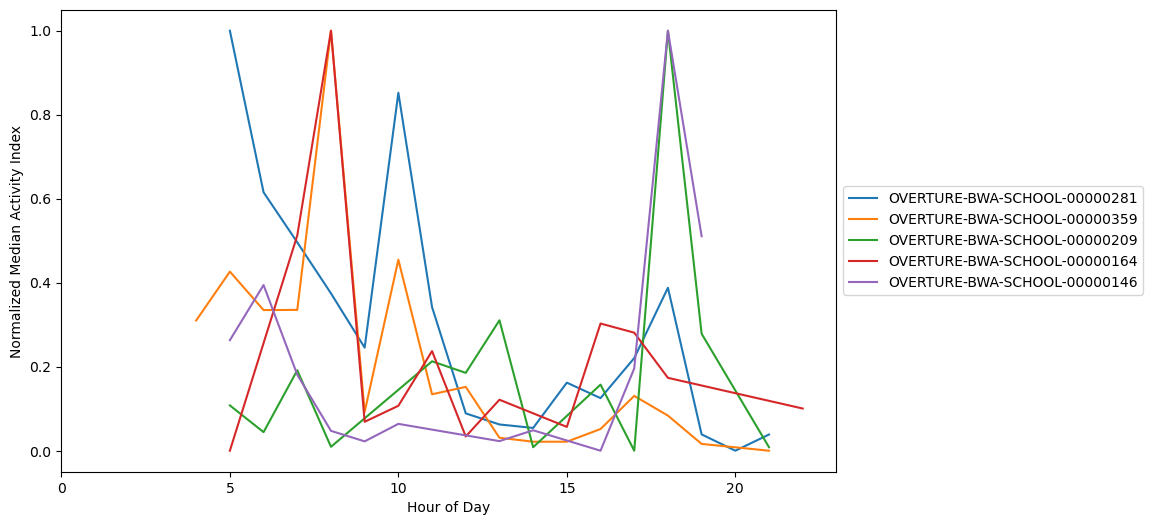

In [194]:
df = mobile_dict['South-East District']['schools_weekday_ai']
plt.figure(figsize=(10,6))
for school in list(top_5_se['schools_weekday_ai'].keys()):
    df_sorted = df[df['UID'] == school].sort_values(by='agg_time_period')
    norm_vals = minmax_norm(df_sorted[df_sorted['UID'] == school]['activity_index_total'])
    plt.plot(df_sorted[df_sorted['UID'] == school]['agg_time_period'], norm_vals, label=school)
    plt.xlim(0,23)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Median Activity Index')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [197]:
top_5_nw['schools_weekday_ai']

{'UNICEF-BWA-SCHOOL-00000090': 17,
 'OVERTURE-BWA-SCHOOL-00000289': 15,
 'OVERTURE-BWA-SCHOOL-00000070': 5,
 'OVERTURE-BWA-SCHOOL-00000019': 3,
 'OVERTURE-BWA-SCHOOL-00000280': 2}

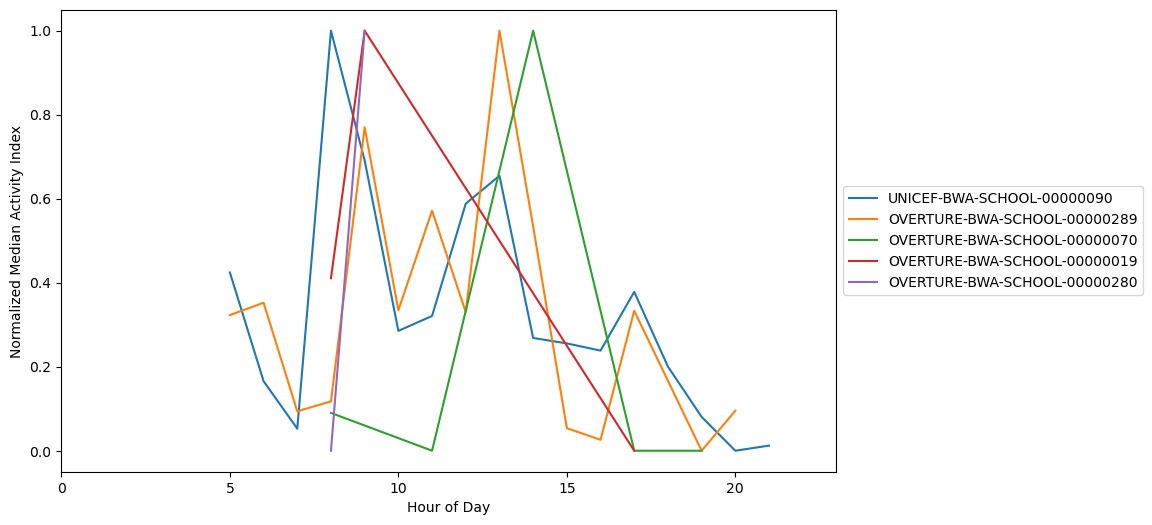

In [199]:
df = mobile_dict['North-West District']['schools_weekday_ai']
plt.figure(figsize=(10,6))
for school in list(top_5_nw['schools_weekday_ai'].keys()):
    df_sorted = df[df['UID'] == school].sort_values(by='agg_time_period')
    norm_vals = minmax_norm(df_sorted[df_sorted['UID'] == school]['activity_index_total'])
    plt.plot(df_sorted[df_sorted['UID'] == school]['agg_time_period'], norm_vals, label=school)
    plt.xlim(0,23)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Median Activity Index')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Administrative Boundaries 1 Analysis

### Max-Min Normalized Analysis

In [ ]:
mobility_dict_inter = pickle.load(open("{}/MaxMinNormalized/dict_of_mobility_dfs_no_agg.p".format(root_dir), "rb"))

In [ ]:
top_5_dict = {}
for k in list(mobility_dict_inter.keys()):
    top_5_dict[k] = [
        get_top_5_aois(mobility_dict_inter, k, 'nov', 'schools_weekday_ai'),
        get_top_5_aois(mobility_dict_inter, k, 'nov', 'schools_weekend_ai'),
        get_top_5_aois(mobility_dict_inter, k, 'nov', 'nonschools_weekday_ai'),
        get_top_5_aois(mobility_dict_inter, k, 'nov', 'nonschools_weekend_ai'),
    ]

In [ ]:
save_directory = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/Mobility_Analysis_Figs'

for cluster in list(mobility_dict_inter.keys()):
    print('Running for cluster: {}'.format(cluster))
    plotting_top_5_aois(mobility_dict_inter, top_5_dict, cluster, 'nov', 'weekday', save_directory)
    plotting_top_5_aois(mobility_dict_inter, top_5_dict, cluster, 'nov', 'weekend', save_directory)

In [ ]:
mobility_dict_inter = pickle.load(open("{}/MaxMinNormalized/dict_of_mobility_dfs.p".format(root_dir), "rb"))

In [ ]:
# South-East District Nov
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.ylim(0,1)
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.plot(mobility_dict_inter['South-East District']['nov']['schools_hourly_weekday_ai']['activity_index_total'], label='Weekday', color='green')
plt.plot(mobility_dict_inter['South-East District']['nov']['schools_hourly_weekend_ai']['activity_index_total'], label='Weekend', color='magenta')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# North-West District Nov
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.ylim(0,1)
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.plot(mobility_dict_inter['North-West District']['nov']['schools_hourly_weekday_ai']['activity_index_total'], label='Weekday', color='green')
plt.plot(mobility_dict_inter['North-West District']['nov']['schools_hourly_weekend_ai']['activity_index_total'], label='Weekend', color='magenta')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Raw output median aggregation
Using median instead of mean aggregation, plotting the data for the ppt, hard coding first for Nov

In [130]:
nov_mobility_dict_inter_med = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_median_mobility_dfs_adm1_nov.p", "rb"))

In [250]:
oct_mobility_dict_inter_med = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_median_mobility_dfs_adm1_oct.p", "rb"))

In [251]:
dec_mobility_dict_inter_med = pickle.load(open("/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_median_mobility_dfs_adm1_dec.p", "rb"))

In [263]:
month = 'dec'
mobility_dict_inter_med = dec_mobility_dict_inter_med

In [187]:
def minmax_norm(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

### South-East

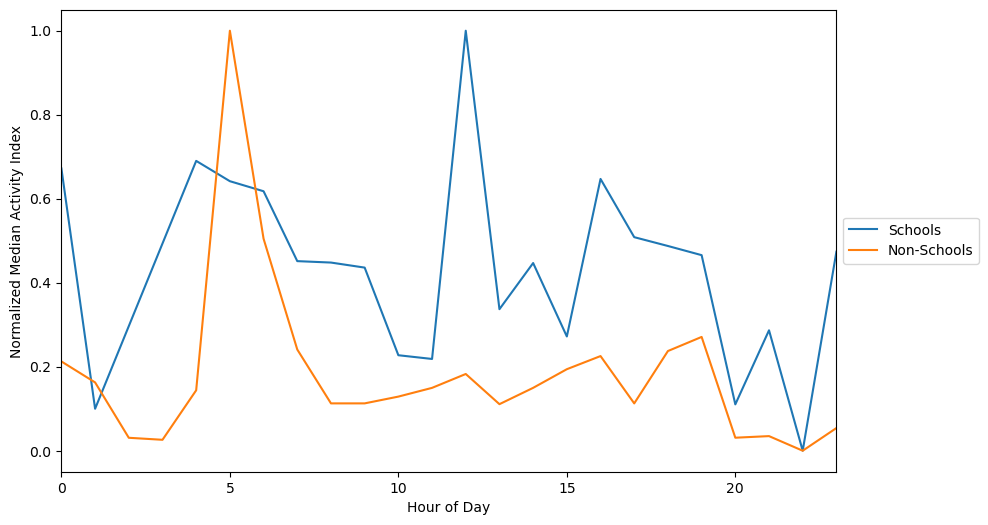

In [264]:
# South-East District
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['schools_weekday_ai']), label='Schools')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['nonschools_weekday_ai']), label='Non-Schools')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

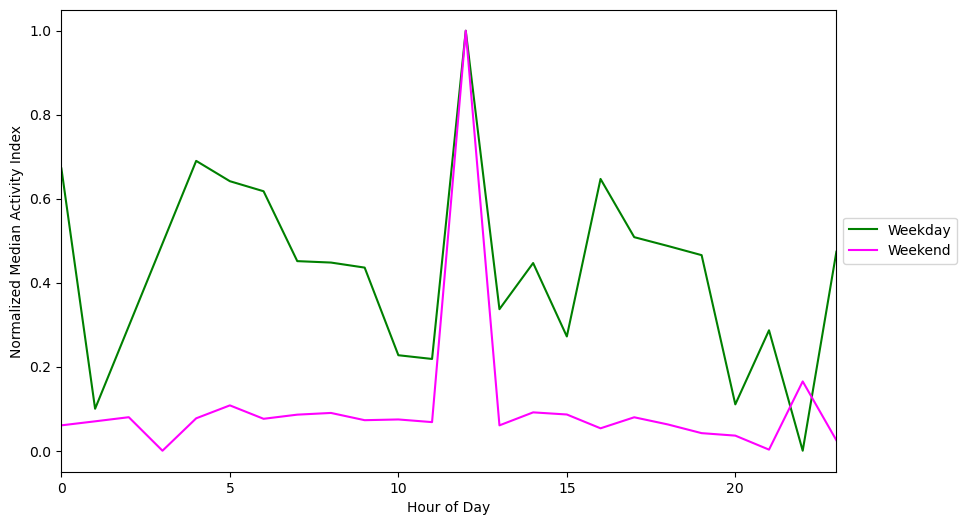

In [265]:
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['schools_weekday_ai']), label='Weekday', color='green')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['schools_weekend_ai']), label='Weekend', color='magenta')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

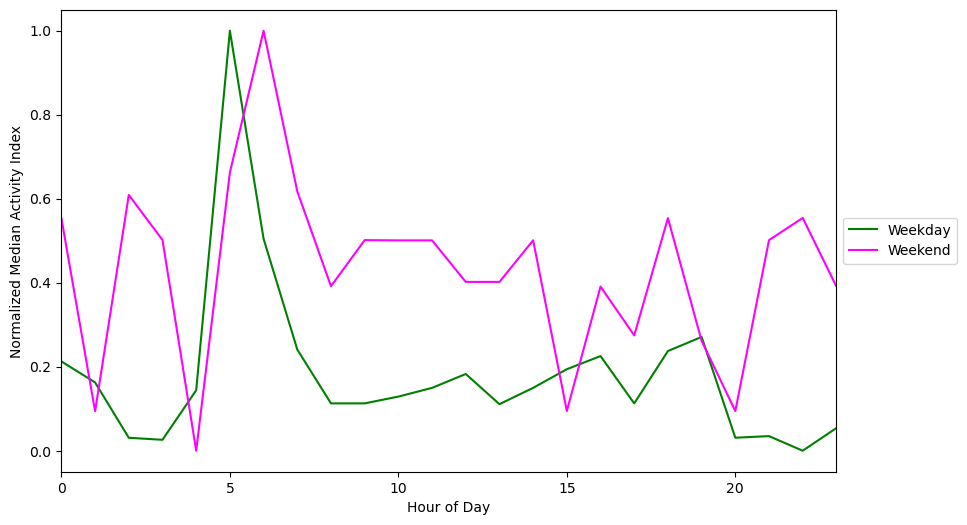

In [266]:
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['nonschools_weekday_ai']), label='Weekday', color='green')
plt.plot(minmax_norm(mobility_dict_inter_med['South-East District']['nonschools_weekend_ai']), label='Weekend', color='magenta')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## North-West

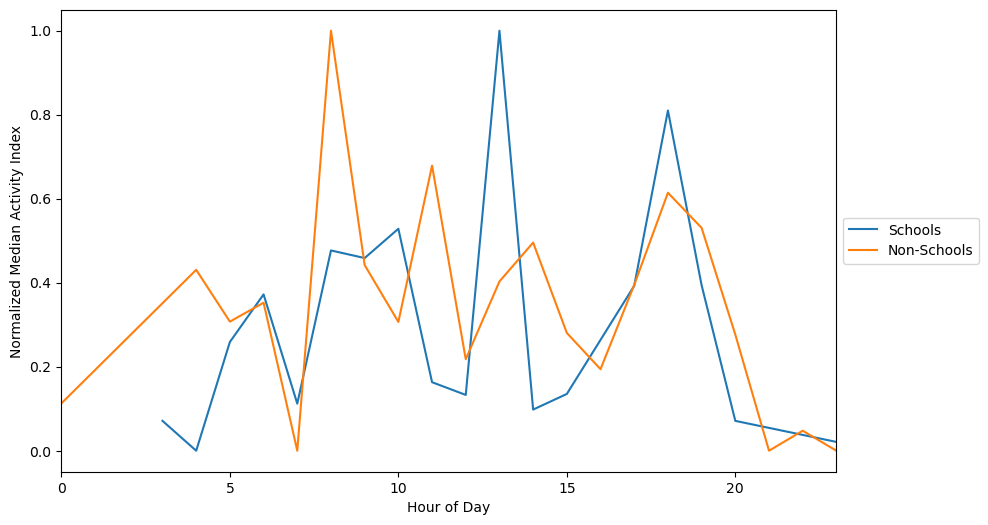

In [267]:
# North-West District Nov
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['schools_weekday_ai']), label='Schools')
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['nonschools_weekday_ai']), label='Non-Schools')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

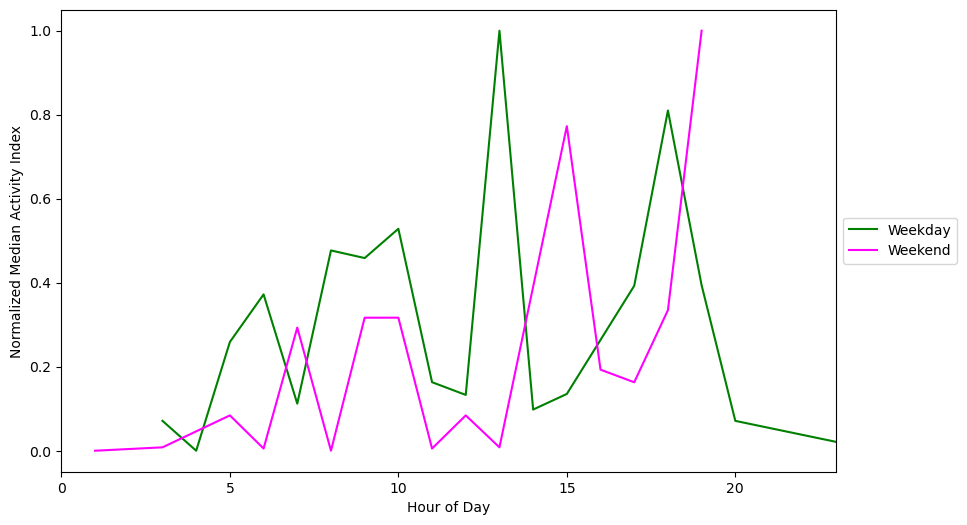

In [268]:
# North-West District Nov
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['schools_weekday_ai']), label='Weekday', color="green")
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['schools_weekend_ai']), label='Weekend', color="magenta")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

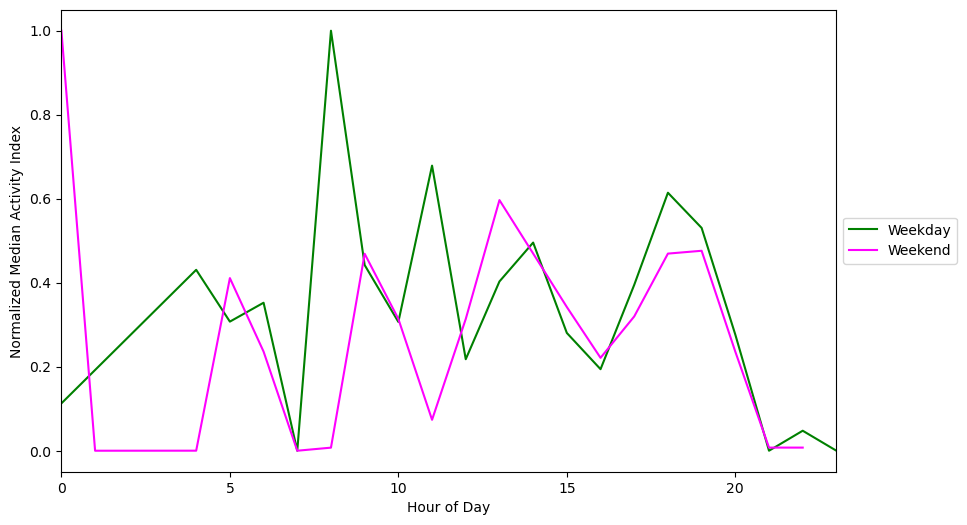

In [269]:
# North-West District Nov
plt.figure(figsize=(10,6))
plt.xlim(0,23)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Median Activity Index')
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['nonschools_weekday_ai']), label='Weekday', color="green")
plt.plot(minmax_norm(mobility_dict_inter_med['North-West District']['nonschools_weekend_ai']), label='Weekend', color="magenta")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 4 Cluster Analysis

In [ ]:
mobility_dict_4clusters = pickle.load(open("{}/MaxMinNormalized/dict_of_mobility_dfs_no_agg_4clusters.p".format(root_dir), "rb"))

In [ ]:
top_5_dict_4_clusters = {}
for k in list(mobility_dict_4clusters.keys()):
    top_5_dict[k] = [
        get_top_5_aois(mobility_dict_4clusters, k, 'nov', 'schools_weekday_ai'),
        get_top_5_aois(mobility_dict_4clusters, k, 'nov', 'schools_weekend_ai'),
        get_top_5_aois(mobility_dict_4clusters, k, 'nov', 'nonschools_weekday_ai'),
        get_top_5_aois(mobility_dict_4clusters, k, 'nov', 'nonschools_weekend_ai'),
    ]

In [ ]:
save_directory = '/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/Mobility_Analysis_Figs'

for cluster in list(mobility_dict_4clusters.keys()):
    print('Running for cluster: {}'.format(cluster))
    plotting_top_5_aois(mobility_dict_4clusters, top_5_dict, cluster, 'nov', 'weekday', save_directory)
    plotting_top_5_aois(mobility_dict_4clusters, top_5_dict, cluster, 'nov', 'weekend', save_directory)

# Extracting Features for ML model
Extracting features from the time series data to be used as features for the school/non-school prediction task. This should be per-sample that has mobility data; if we do this on a cluster-level, the model will be "cheating"

In [ ]:
def generate_timeseries_features(df_subset):
    """
    Function to generate time series features
    from the mobility data to use in the ML model
    Feature space
    
    :param: df_subset: subset df of cluster we are interested in
    """
    features = {}
    
    # Check for schools
    
    if df_subset['schools_weekday_ai'] is None:
        features['schools_weekday_var'] = np.nan
        features['schools_weekday_max'] = np.nan
    else:
        features['schools_weekday_var'] = df_subset['schools_weekday_ai'].var()
        features['schools_weekday_max'] = df_subset['schools_weekday_ai'].idxmax()
        
    if df_subset['schools_weekend_ai'] is None:
        features['schools_weekend_var'] = np.nan
        features['schools_weekend_max'] = np.nan
    else:
        features['schools_weekend_var'] = df_subset['schools_weekend_ai'].var()
        features['schools_weekend_max'] = df_subset['schools_weekend_ai'].idxmax()
        
    # Check for non-schools
    if df_subset['nonschools_weekday_ai'] is None:
        features['nonschools_weekday_var'] = np.nan
        features['nonschools_weekday_max'] = np.nan
    else:
        features['nonschools_weekday_var'] = df_subset['nonschools_weekday_ai'].var()
        features['nonschools_weekday_max'] = df_subset['nonschools_weekday_ai'].idxmax()
        
    if df_subset['nonschools_weekend_ai'] is None:
        features['nonschools_weekend_var'] = np.nan
        features['nonschools_weekend_max'] = np.nan
    else:
        features['nonschools_weekend_var'] = df_subset['nonschools_weekend_ai'].var()
        features['nonschools_weekend_max'] = df_subset['nonschools_weekend_ai'].idxmax()
        
    return features

In [ ]:
adm1_data_med = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_median_mobility_dfs_adm1_nov.p', "rb"))

In [ ]:
adm1_data_mean = pickle.load(open('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/Mobility/dict_of_agg_mobility_dfs_adm1_nov.p', "rb"))

In [ ]:
feature_dict = {}
cluster_names = list(adm1_data_med.keys())
for c in cluster_names:
    features = generate_timeseries_features(adm1_data[c])
    feature_dict['{}_features'.format(c)] = features

In [ ]:
# Load in samples df, add clusters and then add feature info
# Loading BWA school geojson data
BWA_samples = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/BWA_train.geojson')
# Add cluster id to samples
BWA_samples_clustered = cluster_via_adm(BWA_samples, 1)

In [112]:
def add_features_per_cluster(aoi_sample_df, feature_dictionary):
    """
    Create a df of features for the cluster, uid specified
    :param: sample_df: df of samples to get ordered UID from
    :param: feature_dictionary: dictionary of features previously generated
    """
    aoi_sample_df = aoi_sample_df.sort_values(by='UID')
    UID_ordered = aoi_sample_df['UID'].to_list()
    cluster_names_ordered = aoi_sample_df['shapeName'].to_list()
    features_to_add = {
        'schools_weekday_var': [],
        'schools_weekend_var': [],
        'nonschools_weekday_var': [],
        'nonschools_weekend_var': [],
        'schools_weekday_max': [],
        'schools_weekend_max': [],
        'nonschools_weekday_max': [],
        'nonschools_weekend_max': [],
    }
    for i in range(len(UID_ordered)):
        features_to_add['schools_weekday_var'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['schools_weekday_var'])
        features_to_add['schools_weekend_var'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['schools_weekend_var'])
        features_to_add['nonschools_weekday_var'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['nonschools_weekday_var'])
        features_to_add['nonschools_weekend_var'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['nonschools_weekend_var'])
        features_to_add['schools_weekday_max'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['schools_weekday_max'])
        features_to_add['schools_weekend_max'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['schools_weekend_max'])
        features_to_add['nonschools_weekday_max'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['nonschools_weekday_max'])
        features_to_add['nonschools_weekend_max'].append(feature_dictionary['{}_features'.format(cluster_names_ordered[i])]['nonschools_weekend_max'])
        
    
    df = pd.DataFrame.from_dict(features_to_add)
    df['UID'] = UID_ordered
    return df

In [113]:
df_feats = add_features_per_cluster(BWA_samples_clustered, feature_dict)

In [218]:
# Adding to engineered features
# Load pre-processed features
training_df = pd.read_csv('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/1000m_buffer/TrainingData_uncorrelated.csv')
testing_df = pd.read_csv('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/1000m_buffer/TestingData_uncorrelated.csv')

In [243]:
def add_mobility_features(query_df, mobile_feat_df):
    """
    Add mobility features, subsetting into class, adding features then combining
    :param: query_df: original df to add feature to
    :pararm: mobile_feat_df: df of mobile features
    """
    
    school_class = query_df[query_df['class'] == 1]
    nonschool_class = query_df[query_df['class'] == 0]
    
    mobile_feats_school = mobile_feat_df[mobile_feat_df['UID'].isin(school_class['UID'].to_list())]
    mobile_feats_nonschool = mobile_feat_df[mobile_feat_df['UID'].isin(nonschool_class['UID'].to_list())]
    
    combined_schools = pd.merge(school_class, mobile_feats_school, on='UID')
    # Drop non-school columns
    combined_schools = combined_schools.drop(columns=['nonschools_weekday_var', 'nonschools_weekend_var',
                                                     'nonschools_weekday_max', 'nonschools_weekend_max'])
    # Rename school columns
    combined_schools = combined_schools.rename(columns={'schools_weekday_var': 'weekday_var', 'schools_weekend_var': 'weekend_var',
                                    'schools_weekday_max': 'weekday_max', 'schools_weekend_max': 'weekend_max'})
    
    
    combined_nonschools = pd.merge(nonschool_class, mobile_feats_nonschool, on='UID')
    combined_nonschools = combined_nonschools.drop(columns=['schools_weekday_var', 'schools_weekend_var',
                                                     'schools_weekday_max', 'schools_weekend_max'])
    combined_nonschools = combined_nonschools.rename(columns={'nonschools_weekday_var': 'weekday_var', 'nonschools_weekend_var': 'weekend_var',
                                    'nonschools_weekday_max': 'weekday_max', 'nonschools_weekend_max': 'weekend_max'})
                               
    total_combined = pd.concat([combined_schools,combined_nonschools], ignore_index=True)
    
    return total_combined

In [247]:
train_combine = add_mobility_features(training_df, df_feats)
test_combine = add_mobility_features(testing_df, df_feats)

In [248]:
train_combine.to_csv('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/1000m_buffer/TrainingData_uncorrelated_added_mobility.csv')
test_combine.to_csv('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/1000m_buffer/TestingData_uncorrelated_added_mobility.csv')